In [1]:
!pip install wordllama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 3.7 MB/s eta 0:00:00


['object-oriented programming', 'inheritance', 'composition', 'interface classes', 'java applets', 'java applications', 'java class libraries', 'swing toolkit', 'network package', 'collections package.']
['classes', 'inheritance', 'polymorphism', 'encapsulation', 'overloading', 'composition']
['object-oriented design', 'inheritance', 'composition', 'encapsulation', 'polymorphism', 'data abstraction', 'information hiding', 'class-based programming', 'overloading', 'file processing', 'templates', 'exceptions', 'container classes', 'low-level language features']
['object-oriented design', 'architecture', 'design', 'implementation', 'server-side programming', 'client-side web programming', 'spring mvc', 'hibernate', 'dojo', 'jquery', 'web frameworks', 'multitier applications']
['cloud computing', 'cloud architectures', 'cloud security', 'cloud governance', 'cloud storage', 'cloud virtualization', 'cloud capacity', 'cloud applications', 'internet evolution.']
['operating systems', 'system p

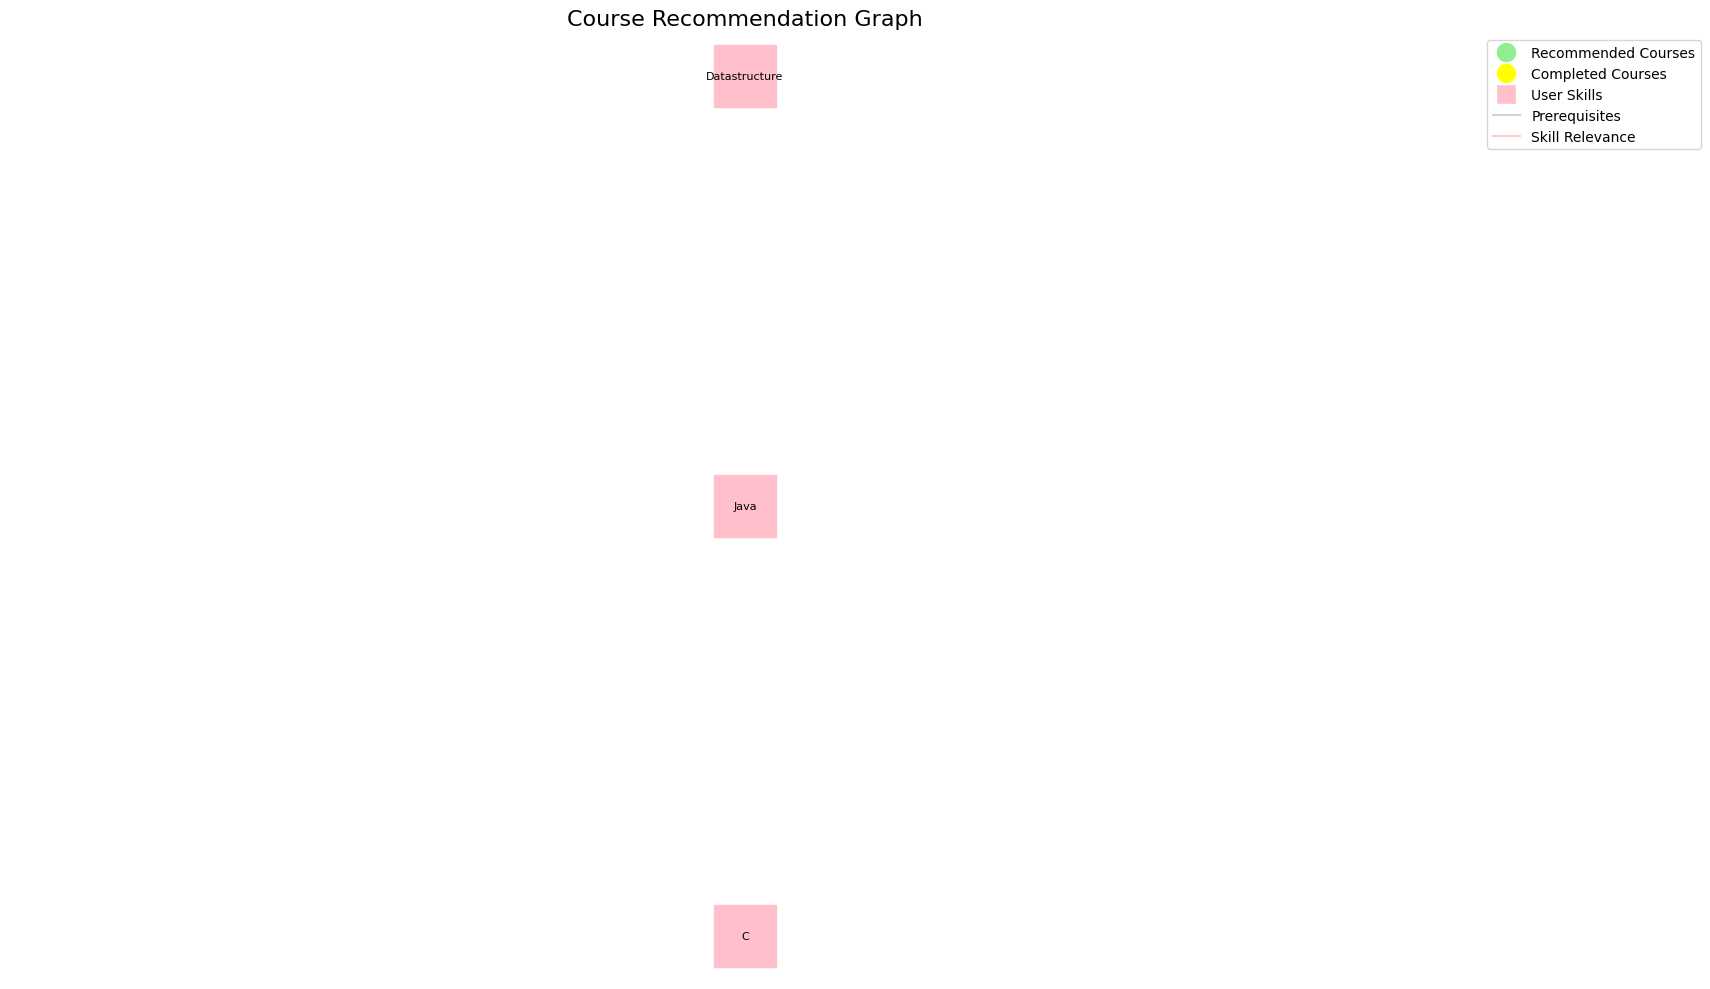


Final Recommendations:
[]


In [2]:
import json
import numpy as np
import pandas as pd
import networkx as nx
from wordllama import WordLlama
import requests
import matplotlib.pyplot as plt
# Load the WordLlama model
import time
wl = WordLlama.load()


def get_additional_keywords(description):
    url = "https://api.perplexity.ai/chat/completions"
    payload = {
        "model": "llama-3.1-sonar-small-128k-online",
        "messages": [
            {
                "role": "system",
                "content": "Extract 3-5 relevant technical skills or keywords from the given course description. Respond with a comma-separated list of keywords only."
            },
            {
                "role": "user",
                "content": f"Course description: {description}"
            }
        ],
        "max_tokens": 50,
        "temperature": 1,
        "top_p": 0.9,
        "return_citations": False,
        "search_domain_filter": ["perplexity.ai"],
        "return_images": False,
        "return_related_questions": False,
        "search_recency_filter": "month",
        "top_k": 0,
        "stream": False,
        "presence_penalty": 0,
        "frequency_penalty": 1
    }
    headers = {
        "Authorization": "Bearer api_key_here",
        "Content-Type": "application/json"
    }
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        keywords = response.json()['choices'][0]['message']['content'].split(',')
        return [keyword.strip().lower() for keyword in keywords]
    else:
        print(f"Error in API call: {response.status_code}")
        return []

def create_course_graph(courses_df):
    G = nx.DiGraph()

    for _, course in courses_df.iterrows():
        time.sleep(3)
        additional_keywords = get_additional_keywords(course['course_description'])
        print(additional_keywords)
        skills_associated = course['skills_associated'] if isinstance(course['skills_associated'], list) else [course['skills_associated']]
        # print(skills_associated)
        all_skills = set(skills_associated + additional_keywords)
        G.add_node(course['course_id'], name=course['course_name'], skills=list(all_skills))
        for prereq in ['prerequisite_1', 'prerequisite_2', 'prerequisite_3']:
            if course[prereq] and course[prereq] != 'None':
                G.add_edge(course[prereq], course['course_id'])

    return G

def calculate_similarity(user_skills, course_skills):
    user_skills_text = " ".join(user_skills)
    course_skills_text = " ".join(course_skills)
    return wl.similarity(user_skills_text, course_skills_text)

def get_course_recommendations(G, user_skills, similarity_scores, available_courses, n=5):
    recommendations = []
    for course_id in available_courses:
        if course_id in similarity_scores:
            score = similarity_scores[course_id]
            course_skills = set(G.nodes[course_id]['skills'])
            skill_overlap = len(course_skills.intersection(user_skills)) / len(course_skills) if course_skills else 0
            combined_score = 0.7 * score + 0.3 * skill_overlap
            print(f"Course: {course_id}, Score: {combined_score:.2f}")
            recommendations.append((course_id, combined_score))

    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return sorted_recommendations[:n]

def get_available_courses(G, user_completed_courses):
    available_courses = set()
    for course in G.nodes():
        if course not in user_completed_courses:
            prereqs = list(G.predecessors(course))
            if all(prereq in user_completed_courses for prereq in prereqs):
                available_courses.add(course)
    return available_courses
def match_course_names(user_courses, course_df):
    matched_courses = []
    for user_course in user_courses:
        similarities = course_df['course_name'].apply(lambda x: wl.similarity(user_course, x))
        best_match_index = similarities.idxmax()
        if similarities[best_match_index] > 0.7:  # You can adjust this threshold
            matched_courses.append(course_df.loc[best_match_index, 'course_id'])
    return matched_courses
def visualize_course_graph(G, recommended_courses, user_completed_courses, user_skills):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Create a subgraph with only the relevant courses
    relevant_courses = set(recommended_courses + user_completed_courses)
    for course in recommended_courses:
        relevant_courses.update(G.predecessors(course))
    subgraph = G.subgraph(relevant_courses)

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color='lightgray', arrows=True)

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightblue')

    # Highlight recommended courses
    nx.draw_networkx_nodes(subgraph, pos, nodelist=recommended_courses, node_size=3000, node_color='lightgreen')

    # Highlight user completed courses
    nx.draw_networkx_nodes(subgraph, pos, nodelist=user_completed_courses, node_size=3000, node_color='yellow')

    # Add course labels
    labels = nx.get_node_attributes(subgraph, 'name')
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

    # Add user skills as separate nodes
    skill_pos = {skill: (pos[list(pos.keys())[0]][0] - 0.3, pos[list(pos.keys())[0]][1] + i*0.1) for i, skill in enumerate(user_skills)}
    nx.draw_networkx_nodes(subgraph, skill_pos, nodelist=user_skills, node_color='pink', node_shape='s', node_size=2000)
    nx.draw_networkx_labels(subgraph, skill_pos, {skill: skill for skill in user_skills}, font_size=8)

    # Connect user skills to relevant courses
    for course in subgraph.nodes():
        course_skills = set(G.nodes[course]['skills'])
        for skill in user_skills:
            if skill in course_skills:
                plt.plot([skill_pos[skill][0], pos[course][0]], [skill_pos[skill][1], pos[course][1]], 'r-', alpha=0.2)

    plt.title("Course Recommendation Graph", fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Add legend
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Recommended Courses'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=15, label='Completed Courses'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='pink', markersize=15, label='User Skills'),
        plt.Line2D([0], [0], color='lightgray', label='Prerequisites'),
        plt.Line2D([0], [0], color='red', alpha=0.2, label='Skill Relevance')
    ], loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

def recommend_courses():
    # Generate mock data
    courses_df = pd.read_csv('/content/drive/MyDrive/mgen_courses.csv')
    courses_df = courses_df[:14]
    # Create course graph with enhanced skills
    course_graph = create_course_graph(courses_df)

    # Update courses_df with enhanced skills
    courses_df['enhanced_skills'] = [' '.join(course_graph.nodes[course_id]['skills']) for course_id in courses_df['course_id']]

    # Mock user data
    user_skills = ["C", "Java", "Datastructure"]
    user_completed_courses = ["Introduction to Python for Information Systems", "Application Engineering and Development"]

    # Calculate similarity scores
    matched_user_courses = match_course_names(user_completed_courses, courses_df)
    print(f"Matched user courses: {matched_user_courses}")

    available_courses = get_available_courses(course_graph, matched_user_courses)
    print(f"Available courses: {available_courses}")

    similarity_scores = {course_id: calculate_similarity(user_skills, course_graph.nodes[course_id]['skills'])
                         for course_id in courses_df['course_id']}

    print("Similarity scores:")
    for course_id, score in similarity_scores.items():
        print(f"{course_id}: {score:.2f}")

    recommendations = get_course_recommendations(course_graph, set(user_skills), similarity_scores, available_courses)

    if not recommendations:
        print("No recommendations found. Adjusting criteria...")
        # If no recommendations, relax the criteria
        recommendations = get_course_recommendations(course_graph, set(user_skills), similarity_scores, set(course_graph.nodes()), n=10)

    if recommendations:
        recommendation_df = pd.DataFrame(recommendations, columns=['course_id', 'combined_score'])
        recommendation_df = recommendation_df.merge(courses_df[['course_id', 'course_name', 'enhanced_skills']], on='course_id')

        filtered_recommendations = recommendation_df[recommendation_df['combined_score'] > 0.3]
        filtered_recommendations = filtered_recommendations.sort_values('combined_score', ascending=False)

        # Visualize the course graph
        recommended_course_ids = filtered_recommendations['course_id'].tolist()
        visualize_course_graph(course_graph, recommended_course_ids, matched_user_courses, user_skills)

        return filtered_recommendations.to_dict(orient='records')
    else:
        print("No recommendations found even after adjusting criteria.")
        return []

# Run the recommendation system
recommendations = recommend_courses()
print("\nFinal Recommendations:")
print(json.dumps(recommendations, indent=2))

In [ ]:
courses_df = pd.read_csv('/content/drive/MyDrive/mgen_courses.csv')

In [ ]:
courses_df.head()

,course_id,course_name,course_description,prerequisite_1,prerequisite_2,prerequisite_3,major,domain_1,domain_2,skills_associated
0,CSYE6200,Concepts of Object-Oriented Design,Introduces object-oriented design and programm...,NaN,NaN,NaN,CSYE,Software Development,NaN,"Object-oriented, Java, Swing, HCI, C"
1,CSYE6202,Concepts of Object-Oriented Design with C#,Introduces object-oriented design and programm...,NaN,NaN,NaN,CSYE,Software Development,NaN,"Object-oriented, C#, HCI"
2,CSYE6205,Concepts of Object-Oriented Design with C++,Introduces object-oriented design and programm...,NaN,NaN,NaN,CSYE,Software Development,NaN,"Object-oriented, C++, HCI"
3,CSYE6220,Enterprise Software Design,Designed to build on previous experience in co...,CSYE 6200,CSYE 6202,CSYE 6205,CSYE,Software Development,NaN,"Java, Spring, Springboot, MVC, Hibernate, Dojo..."
4,CSYE6225,Network Structures and Cloud Computing,Offers a practical foundation in cloud computi...,CSYE 6200,INFO 5100,NaN,CSYE,Cloud Computing,Software Development,"Cloud, AWS, Google-cloud, GCP, Azure, Backend"
